# Importando Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pickle
import warnings
import os

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, classification_report
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

import mnist_loader

In [2]:
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

# Carregando o MNIST dataset

In [3]:
# Loading MNIST dataset
training_data, validation_data, test_data = mnist_loader.load_data()

X_train, Y_train = np.concatenate((training_data[0], validation_data[0])), np.concatenate((training_data[1], validation_data[1]))
X_test, Y_test = test_data[0], test_data[1]

# Definindo os parâmetros da MLP

Os parâmetros testados em busca do melhor desempenho estão descritos abaixo:
<br>
- Número de camadas: Definido aleatoriamente para cada experimento, de forma que cada MLP testado terá 1 ou mais camadas ocultas, com cada camada sendo adicionada caso o número aleatório retornado pelo random.uniform seja maior do que 0.4
- Número de neurônios: Também definido aleatoriamente para cada experimento e camada, sendo um número entre 2 e 100
- Taxa de aprendizagem: Número definido de forma aleatória entre 0.001 e 0.5, tendo no máximo 4 dígitos
- Função de ativação: Escolhido aleatoriamente, podendo ser 'identity', 'logistic', 'tanh' ou 'relu'
- Algoritmo de aprendizagem: Também escolhido aleatoriamente, podendo ser 'adam' (Adaptive Moment Estimation), 'sgd' (Stochastic Gradient Descent) ou 'lbfgs' (Limited-memory Broyden-Fletcher-Goldfarb-Shanno)

In [4]:
def random_hidden_layers(max_hidden_layer=50, hidden_layer_prob=0.4):
    """
    Gera aleatoriamente o número de camadas escondidas para uma rede neural Multilayer Perceptron (MLP).

    Parâmetros:
    - max_hidden_layer: Número máximo de neurônios em uma camada escondida.
    - hidden_layer_prob: Probabilidade de adicionar uma camada escondida adicional.

    Retorna:
    - hidden_layer: Uma lista representando o número de neurônios em cada camada escondida.
    """
    hidden_layer = [random.randint(2, max_hidden_layer)]
    while random.uniform(0.0, 1.0) > hidden_layer_prob:
        hidden_layer.append(random.randint(2, max_hidden_layer))
    return hidden_layer

def random_params_mlp(verbose=False, num_epochs=250, tol=0.001):
    """
    Gera aleatoriamente os parâmetros para uma rede neural Multilayer Perceptron (MLP).

    Parâmetros:
    - verbose: Se True, mostrar mensagens de progresso durante o treinamento.
    - num_epochs: Número máximo de épocas de treinamento.
    - tol: Tolerância para a otimização.

    Retorna:
    - MLPClassifier: Um classificador MLP com parâmetros aleatórios.
    """
    return MLPClassifier(
        activation=random.choice(['logistic', 'tanh', 'relu']), # 'identity'
        batch_size='auto',
        early_stopping=True,
        hidden_layer_sizes=random_hidden_layers(max_hidden_layer=100),
        learning_rate_init=round(random.uniform(0.0001, 0.5), 4),
        max_iter=num_epochs,
        n_iter_no_change=3,
        solver=random.choice(['adam', 'sgd', 'lbfgs']),
        tol=tol,
        verbose=verbose,
    )

# Fazendo um "GridSearch" sobre a camada escondida

Primeiro vamos definir a estrutura do dataframe para armazenar os resultados obtidos durante o gridsearch

In [5]:
if (os.path.exists('model_metrics.csv')):
    model_df = pd.read_csv('model_metrics.csv')
else:
    model_data = {
        'solver': [],
        'activation_function': [],
        'hidden_layers': [],
        'learning_rate': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': [],
        'fit_time': [],
        'total_epochs': [],
    }
    model_df = pd.DataFrame(model_data)

Em seguida, realizamos 10 experimentos, cada um com parâmetros diferentes escolhidos aleatoriamente usando a biblioteca random, que é nativa do python. Para cada experimento, iremos exibir a acurácia total e tempo de treinamento do modelo testado, além de salvar seus resultados (acurácia total, precisão total, recall total, tempo de treinamento e f1 score) e parâmetros (função de ativação, algoritmo de aprendizagem, número de epochs, número de camadas e neurônios e taxa de aprendizagem).
<br>No final de cada experimento, são salvos os cinco modelos com a maior acurácia total, os quais são exibidos após a conclusão de todos os 10 testes.

In [7]:
trained_models = []

print("Activation | Solver | LR | Hidden Layers | Total Time | Total Epochs -> Accuracy")
for _ in range(10):
    mlp = random_params_mlp(num_epochs=100)

    print(f"{mlp.get_params()['activation']} | {mlp.get_params()['solver']} | {mlp.get_params()['learning_rate_init']} \
| {mlp.get_params()['hidden_layer_sizes']} | ", end='')

    start = time.time()
    mlp.fit(X_train, Y_train)
    end = time.time()
    total_time = round(end - start, 1)

    mlp_predictions = mlp.predict(X_test)
    accuracy = accuracy_score(Y_test, mlp_predictions)
    precision = precision_score(Y_test, mlp_predictions, average='macro')
    recall = recall_score(Y_test, mlp_predictions, average='macro')
    f1 = f1_score(Y_test, mlp_predictions, average='macro')
    print(f"{total_time}s | {mlp.n_iter_} -> {accuracy}")

    trained_models.append((mlp, accuracy))
    trained_models = sorted(trained_models, key=lambda tup: tup[1], reverse=True)[:5]

    # Adicionando o modelo ao dataframe de modelos
    model_df.loc[len(model_df)] = {
        'solver': mlp.get_params()['solver'],
        'activation_function': mlp.get_params()['activation'],
        'hidden_layers': str(mlp.get_params()['hidden_layer_sizes']),
        'learning_rate': mlp.get_params()['learning_rate_init'],
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'fit_time': total_time,
        'total_epochs': mlp.n_iter_,
    }

    model_df.to_csv('model_metrics.csv', index=False)

print("\nTop 5 Models:")
for model, acc in trained_models:
    print(f"Accuracy: {acc}, Params: {model.get_params()['hidden_layer_sizes']}")

Activation | Solver | LR | Hidden Layers | Total Time | Total Epochs -> Accuracy
logistic | sgd | 0.3512 | [38, 75] | 14.9s | 13 -> 0.967
relu | sgd | 0.1129 | [69] | 6.8s | 10 -> 0.9768
tanh | adam | 0.0956 | [5] | 3.7s | 11 -> 0.8225
logistic | lbfgs | 0.4207 | [6, 49, 10, 18, 21, 92, 87] | 8.3s | 3 -> 0.1135
relu | sgd | 0.2816 | [17] | 5.1s | 16 -> 0.9456
logistic | adam | 0.3496 | [59] | 9.2s | 9 -> 0.8714
relu | sgd | 0.1913 | [73, 33] | 9.9s | 16 -> 0.9732
logistic | adam | 0.3899 | [98] | 9.1s | 7 -> 0.8626
logistic | adam | 0.2404 | [84, 60, 53, 21, 30, 54] | 11.9s | 5 -> 0.1028
tanh | lbfgs | 0.1131 | [46] | 12.2s | 51 -> 0.9595

Top 5 Models:
Accuracy: 0.9768, Params: [69]
Accuracy: 0.9732, Params: [73, 33]
Accuracy: 0.967, Params: [38, 75]
Accuracy: 0.9595, Params: [46]
Accuracy: 0.9456, Params: [17]


Acima temos os parâmetros para cada um dos 10 Multilayer Perceptrons testados, junto com sua acurácia total e o tempo que levou para treinar cada um deles. <br>
Nota-se que a maioria dos modelos apresentam uma acurácia parecida, com excessão de alguns modelos que possuem 4 camadas ocultas, com o restante dos modelos apresentando uma acurácia total maior do que 0.89.

Por fim, temos um dataframe que mostra os parâmetros e as métricas gerais para todos os modelos testados até o momento.

In [8]:
model_df.sort_values(['accuracy'], ascending=False)

,solver,activation_function,hidden_layers,learning_rate,accuracy,precision,recall,f1_score,fit_time,total_epochs
303,sgd,logistic,[90],0.4237,0.9782,0.978048,0.977973,0.977996,12.4,16
144,sgd,tanh,"[88, 82, 48]",0.0604,0.9781,0.977912,0.977827,0.977850,16.6,16
365,sgd,relu,[69],0.1129,0.9768,0.976564,0.976674,0.976573,6.8,10
100,lbfgs,relu,[91],0.0790,0.9766,0.976579,0.976383,0.976470,82.1,188
45,sgd,tanh,[89],0.0812,0.9762,0.976047,0.975991,0.976001,11.3,18
...,...,...,...,...,...,...,...,...,...,...
357,adam,relu,"[13, 58, 3]",0.0363,0.1028,0.010280,0.100000,0.018643,2.1,5
361,adam,logistic,"[29, 41, 94, 16, 12]",0.2290,0.1028,0.010280,0.100000,0.018643,7.6,6
333,adam,relu,"[97, 14]",0.3337,0.1028,0.010280,0.100000,0.018643,3.7,5
372,adam,logistic,"[84, 60, 53, 21, 30, 54]",0.2404,0.1028,0.010280,0.100000,0.018643,11.9,5


# Análise da Performance Sobre o Conjunto de Teste

In [9]:
best_model = trained_models[0][0]

In [10]:
mlp_predictions = best_model.predict(X_test)

## Calculando Acurácia, Precisão e Recall

Feita a previsão do modelo com os dados do conjunto de teste, foi calculado a acurácia, precisão, recall total e f1 score  usando as funções accuracy_score, precision_score, recall_score e f1_score, todos da biblioteca scikit-learn.

In [11]:
accuracy = accuracy_score(Y_test, mlp_predictions)
precision = precision_score(Y_test, mlp_predictions, average='macro')
recall = recall_score(Y_test, mlp_predictions, average='macro')
f1 = f1_score(Y_test, mlp_predictions, average='macro')

In [12]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9768
Precision: 0.9765637795973028
Recall: 0.9766744700872712
F1 Score: 0.976572752112453


Além disso, exibimos as principais métricas de classificação (acurácia, precisão, recall e f1 score) para cada classe para que possamos avaliar a confiabilidade do modelo na classificação de cada dígito.

In [13]:
#Pegando o report de cada classe 
report = classification_report(Y_test, mlp_predictions, target_names=['0','1','2','3','4','5','6','7','8','9'], output_dict = True)
conf_matrix = confusion_matrix(Y_test, mlp_predictions )
# Calcular a acurácia para cada classe
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
for i in range(10):
  report[str(i)]['accuracy'] = accuracy_per_class[i]

#Printando a tabela
infoClass = pd.DataFrame(report)
infoClass = infoClass.drop(columns=['accuracy', 'macro avg', 'weighted avg'])
infoClass

,0,1,2,3,4,5,6,7,8,9
precision,0.983707,0.992049,0.970363,0.969185,0.987603,0.953261,0.981112,0.969171,0.982255,0.976931
recall,0.985714,0.989427,0.983527,0.965347,0.973523,0.983184,0.975992,0.978599,0.966119,0.965312
f1-score,0.984709,0.990737,0.976901,0.967262,0.980513,0.967991,0.978545,0.973863,0.974120,0.971087
support,980.000000,1135.000000,1032.000000,1010.000000,982.000000,892.000000,958.000000,1028.000000,974.000000,1009.000000
accuracy,0.985714,0.989427,0.983527,0.965347,0.973523,0.983184,0.975992,0.978599,0.966119,0.965312


## Plotando a Matrix de Confusão

Também exibimos a matriz de confusão abaixo, fornecendo uma outra visão da performance do melhor modelo para cada uma das suas 10 classes, de forma a avaliarmos a quantidade de instâncias de cada classe que o modelo classificou corretamente.

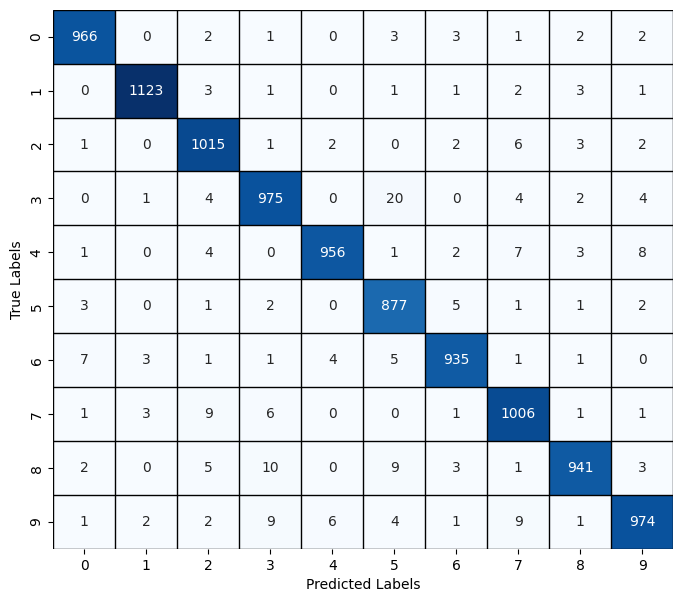

In [14]:
# Confusion Matrix
conf_matrix = confusion_matrix(Y_test, mlp_predictions)
plt.figure(figsize=(8, 7))

# Heatmap
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=range(10), yticklabels=range(10))

# Labels
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

for i in range(11):
    plt.hlines(i, xmin=0, xmax=10, colors='black', linestyles='solid', linewidth=1)
    plt.vlines(i, ymin=0, ymax=10, colors='black', linestyles='solid', linewidth=1)

plt.show()

Observa-se que o modelo tem uma performance boa em todas as classes, acertando a maioria dos casos de teste, confundindo principalmente o dígito 3 com o 5.

## Média e Desvio Padrão das Métricas

Por último, iremos calcular a média e desvio padrão dos 5 melhores conjuntos de parâmetros para ter um melhor entendimento do quão bom é a performance dos modelos treinados com esses parâmetros.

In [15]:
data = {
    'Params': [],
    'Mean Accuracy': [],
    'Std Accuracy': [],
    'Mean Precision': [],
    'Std Precision': [],
    'Mean Recall': [],
    'Std Recall': [],
    'Mean Time': [],
    'Std Time': [],
}

In [16]:
# Criando 10 modelos para as 3 melhores combinações de parâmetros
for i, model in enumerate(trained_models):
    model = model[0]
    accuracy = []
    precision = []
    recall = []
    fit_time = []
    for _ in range(10):
        start = time.time()
        model.fit(X_train, Y_train)
        end = time.time()
        fit_time.append(round(end - start, 1))

        model_predictions = model.predict(X_test)
        accuracy.append(accuracy_score(Y_test, model_predictions))
        precision.append(precision_score(Y_test, model_predictions, average='weighted'))
        recall.append(recall_score(Y_test, model_predictions, average='weighted'))

    data['Params'].append(f"C{i}")
    data['Mean Accuracy'].append(np.mean(accuracy))
    data['Std Accuracy'].append(np.std(accuracy))
    data['Mean Precision'].append(np.mean(precision))
    data['Std Precision'].append(np.std(precision))
    data['Mean Recall'].append(np.mean(recall))
    data['Std Recall'].append(np.std(recall))
    data['Mean Time'].append(np.mean(fit_time))
    data['Std Time'].append(np.std(fit_time))
df = pd.DataFrame(data)

In [17]:
df

,Params,Mean Accuracy,Std Accuracy,Mean Precision,Std Precision,Mean Recall,Std Recall,Mean Time,Std Time
0,C0,0.97466,0.001464,0.974747,0.001443,0.97466,0.001464,5.54,1.456159
1,C1,0.97133,0.001864,0.971445,0.001884,0.97133,0.001864,6.61,1.525418
2,C2,0.96718,0.001950,0.967330,0.001887,0.96718,0.001950,10.23,2.206830
3,C3,0.96255,0.002439,0.962555,0.002442,0.96255,0.002439,11.56,1.004191
4,C4,0.94584,0.004557,0.946250,0.004354,0.94584,0.004557,3.05,0.900278


# Salvando o melhor modelo treinado

Nessa secção está o código para salvar o modelo de melhor performance usando o pickle, outra biblioteca nativa do python.
<br>Salvamos esse modelo em um arquivo .pkl que pode ser aberto posteriormente com o pickle.load(open(caminho_arquivo_pkl, 'rb')).

In [18]:
filename = 'test_model.plk'

In [19]:
# Salvando o modelo em um arquivo
with open(filename, 'wb') as f:
    pickle.dump(best_model, f)

In [ ]:
# # Carregando um modelo salvo
# with open(filename, 'rb') as f:
#     best_model = pickle.load(f)

### Acurácia x Total de Épocas

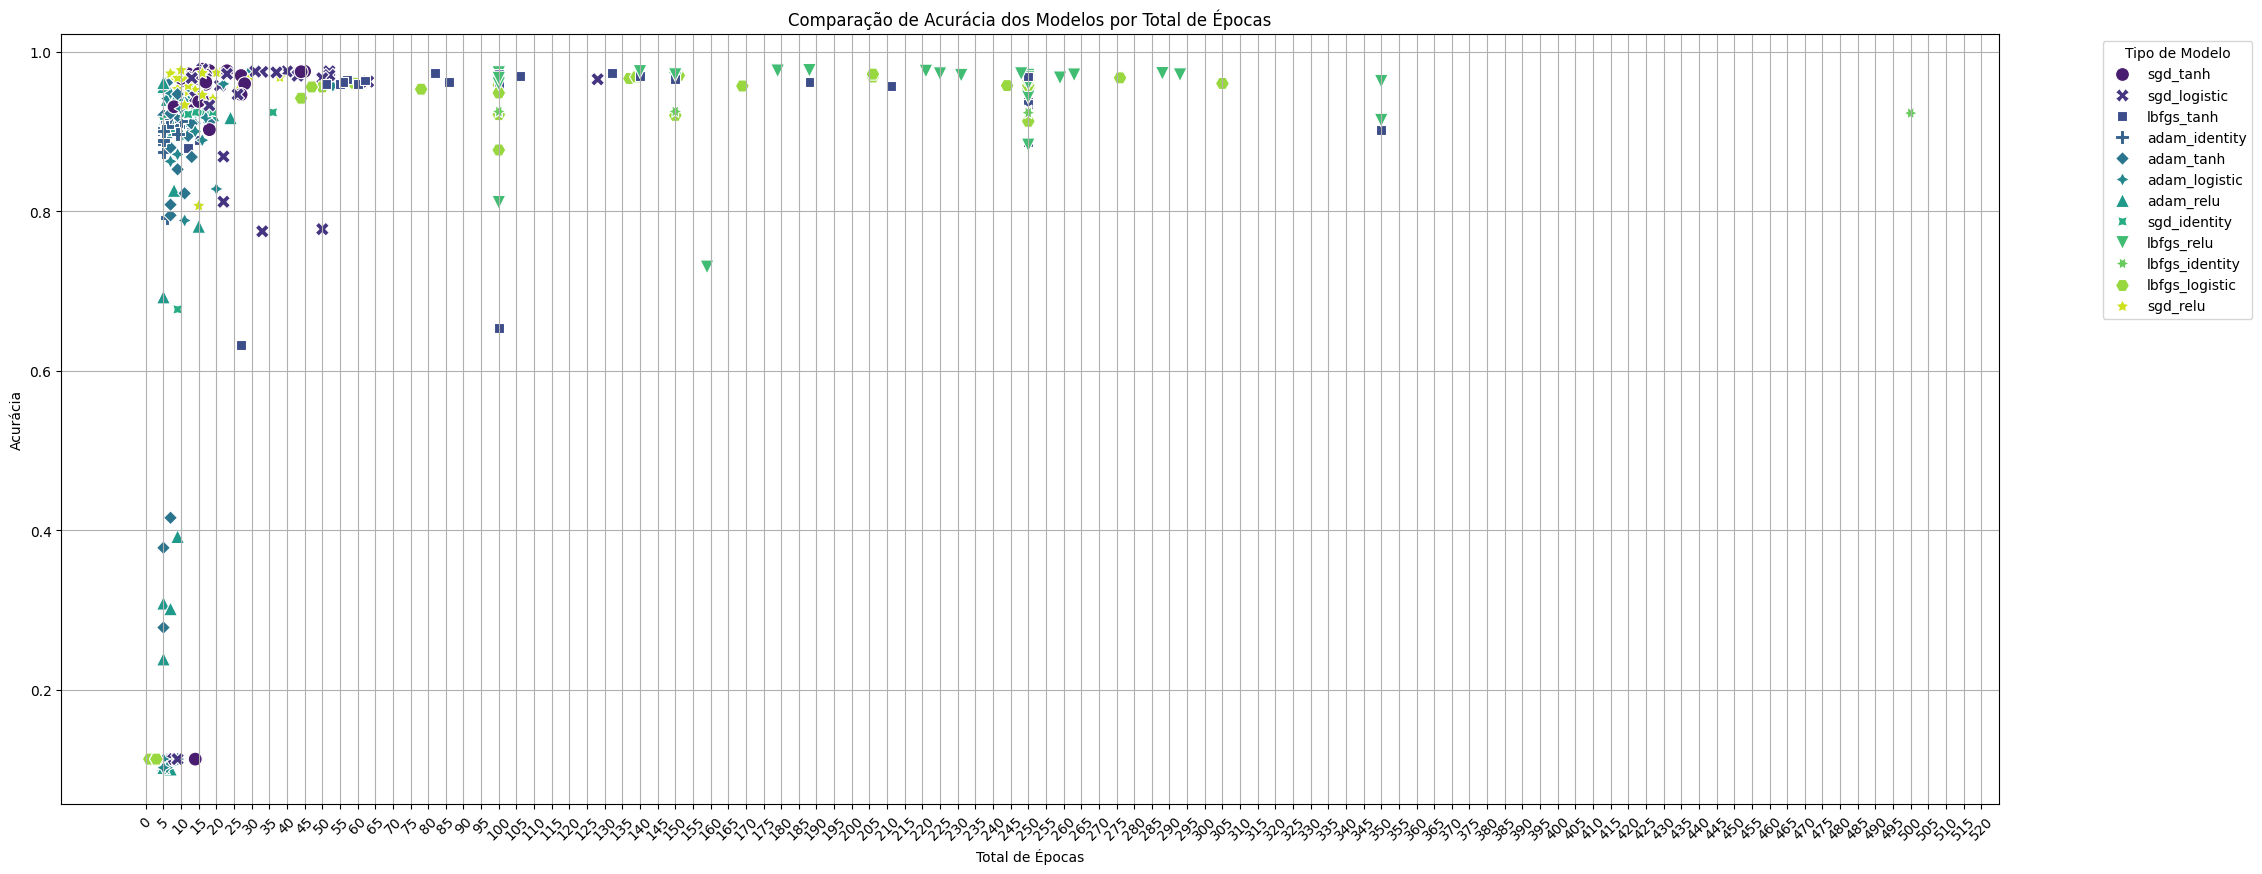

In [34]:
plt.figure(figsize=(25, 10))
model_df['model_type'] = model_df['solver'] + '_' + model_df['activation_function']

sns.scatterplot(data=model_df, x='total_epochs', y='accuracy', hue='model_type', style='model_type', markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Épocas')
plt.xlabel('Total de Épocas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 5))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

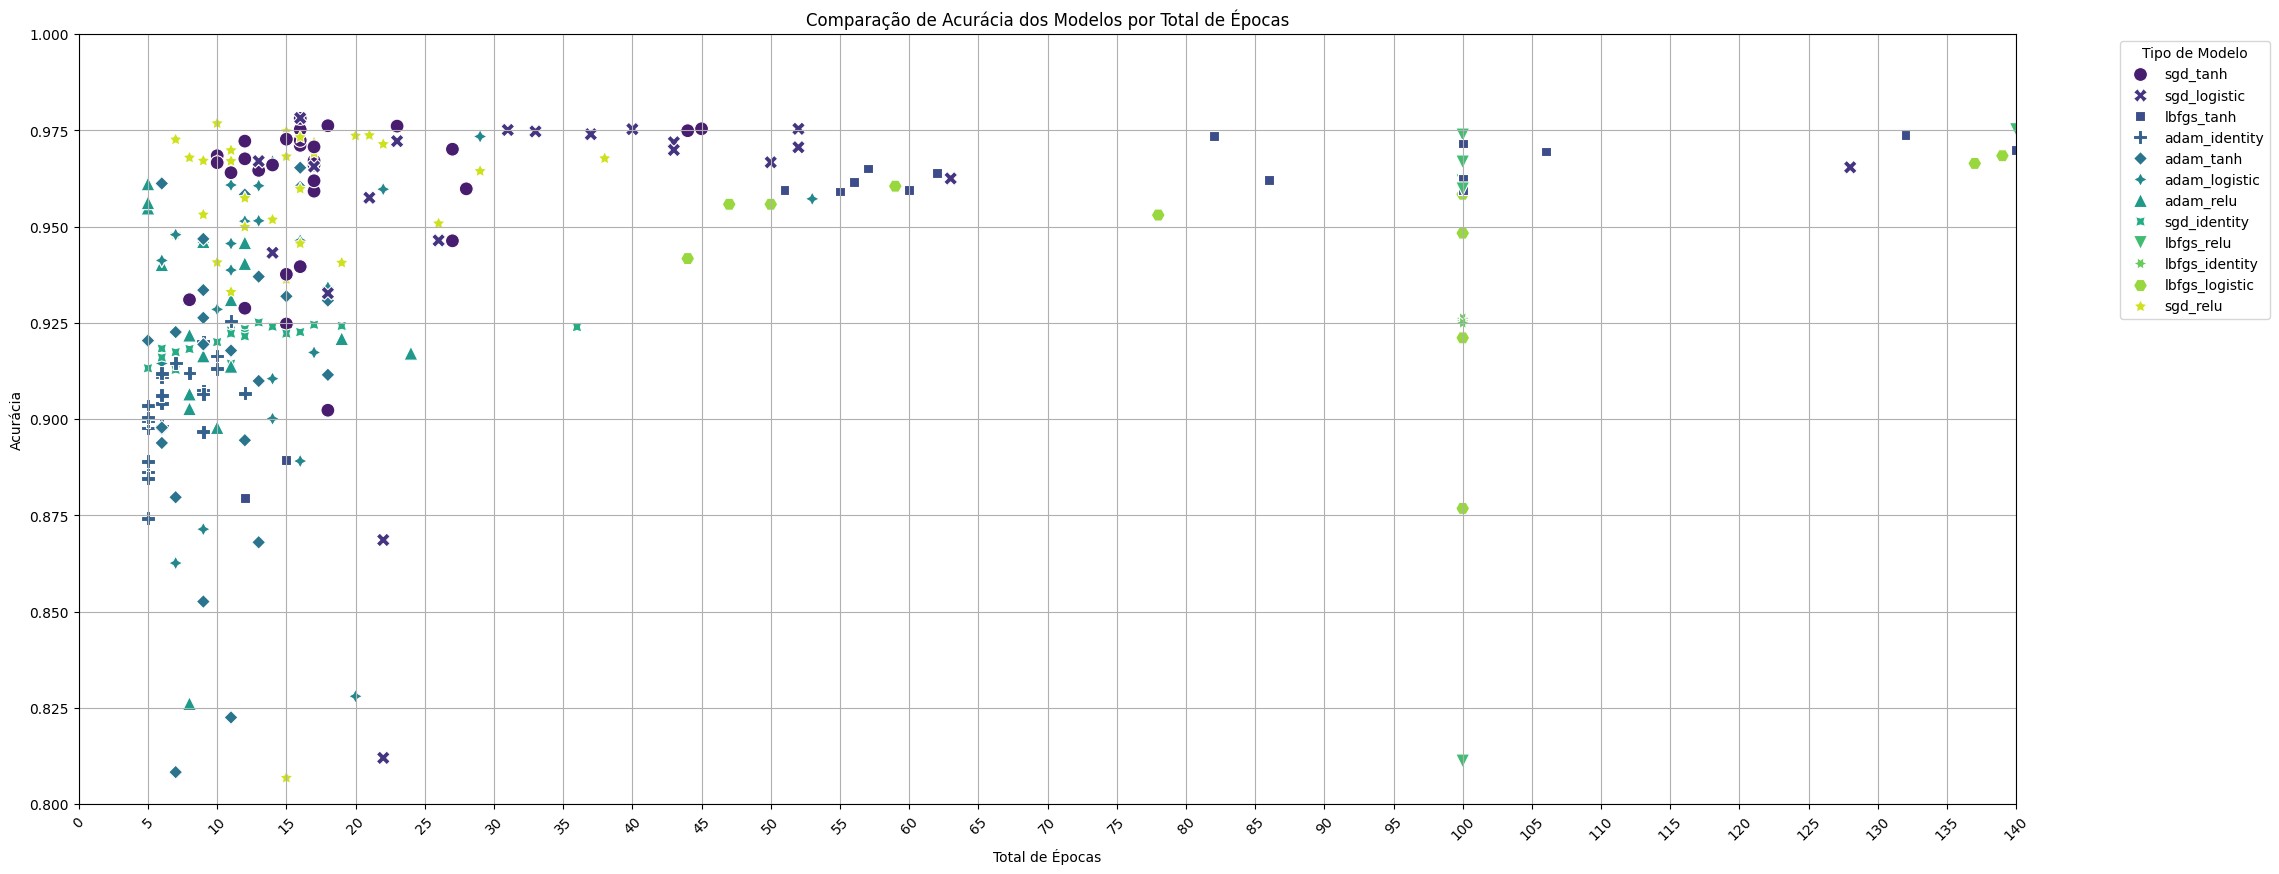

In [35]:

plt.figure(figsize=(25, 10))
model_df['model_type'] = model_df['solver'] + '_' + model_df['activation_function']

sns.scatterplot(data=model_df, x='total_epochs', y='accuracy', hue='model_type', style='model_type', markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Épocas')
plt.xlabel('Total de Épocas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 5))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 


plt.xlim(0, 140)  
plt.ylim(0.8, 1.0) 

plt.show()

### Acurácia x Quantidade Total de Neurônios

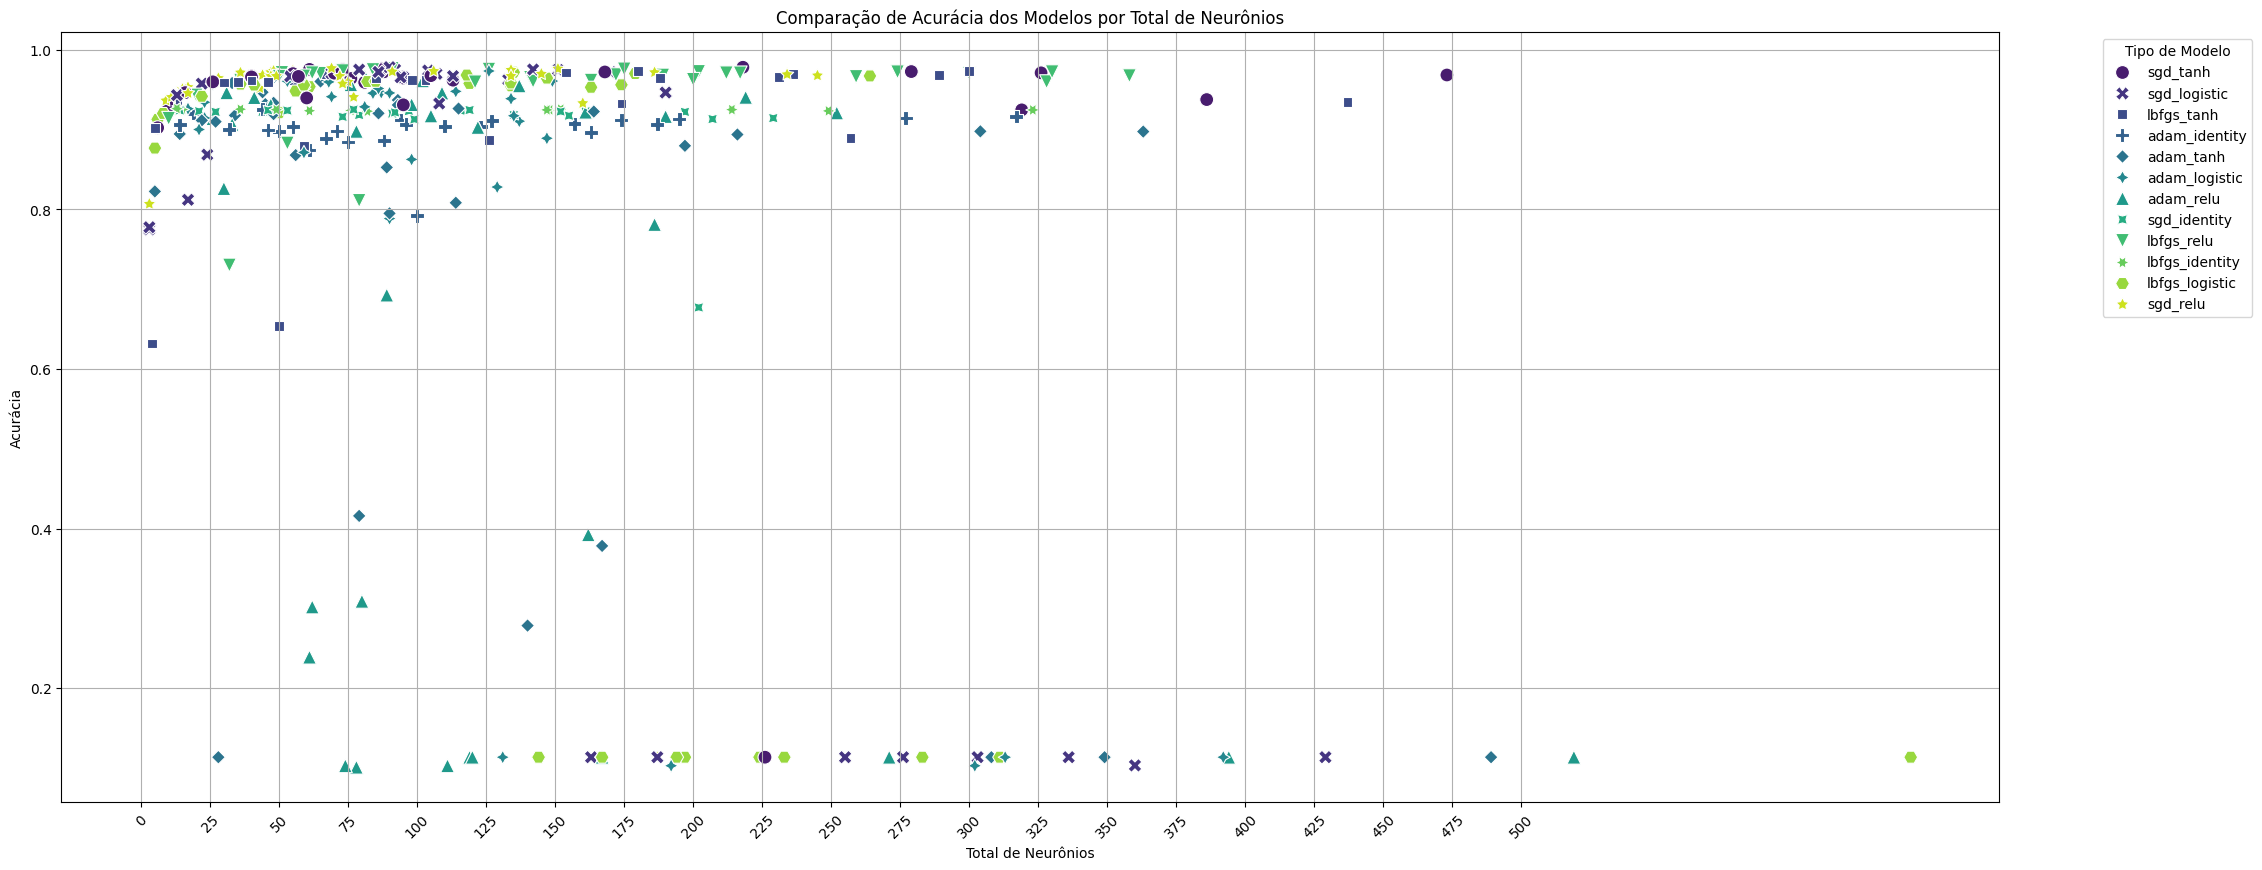

In [36]:
model_df['total_neurons'] = model_df['hidden_layers'].apply(lambda x: sum(eval(x)))

plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=model_df, x='total_neurons', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)  # Ajustando o tamanho dos pontos para melhor visualização

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Total de Neurônios')
plt.xlabel('Total de Neurônios')
plt.ylabel('Acurácia')
plt.xticks(rotation=45, ticks=range(0, 525, 25))
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

### Acurácia x Número de Camadas

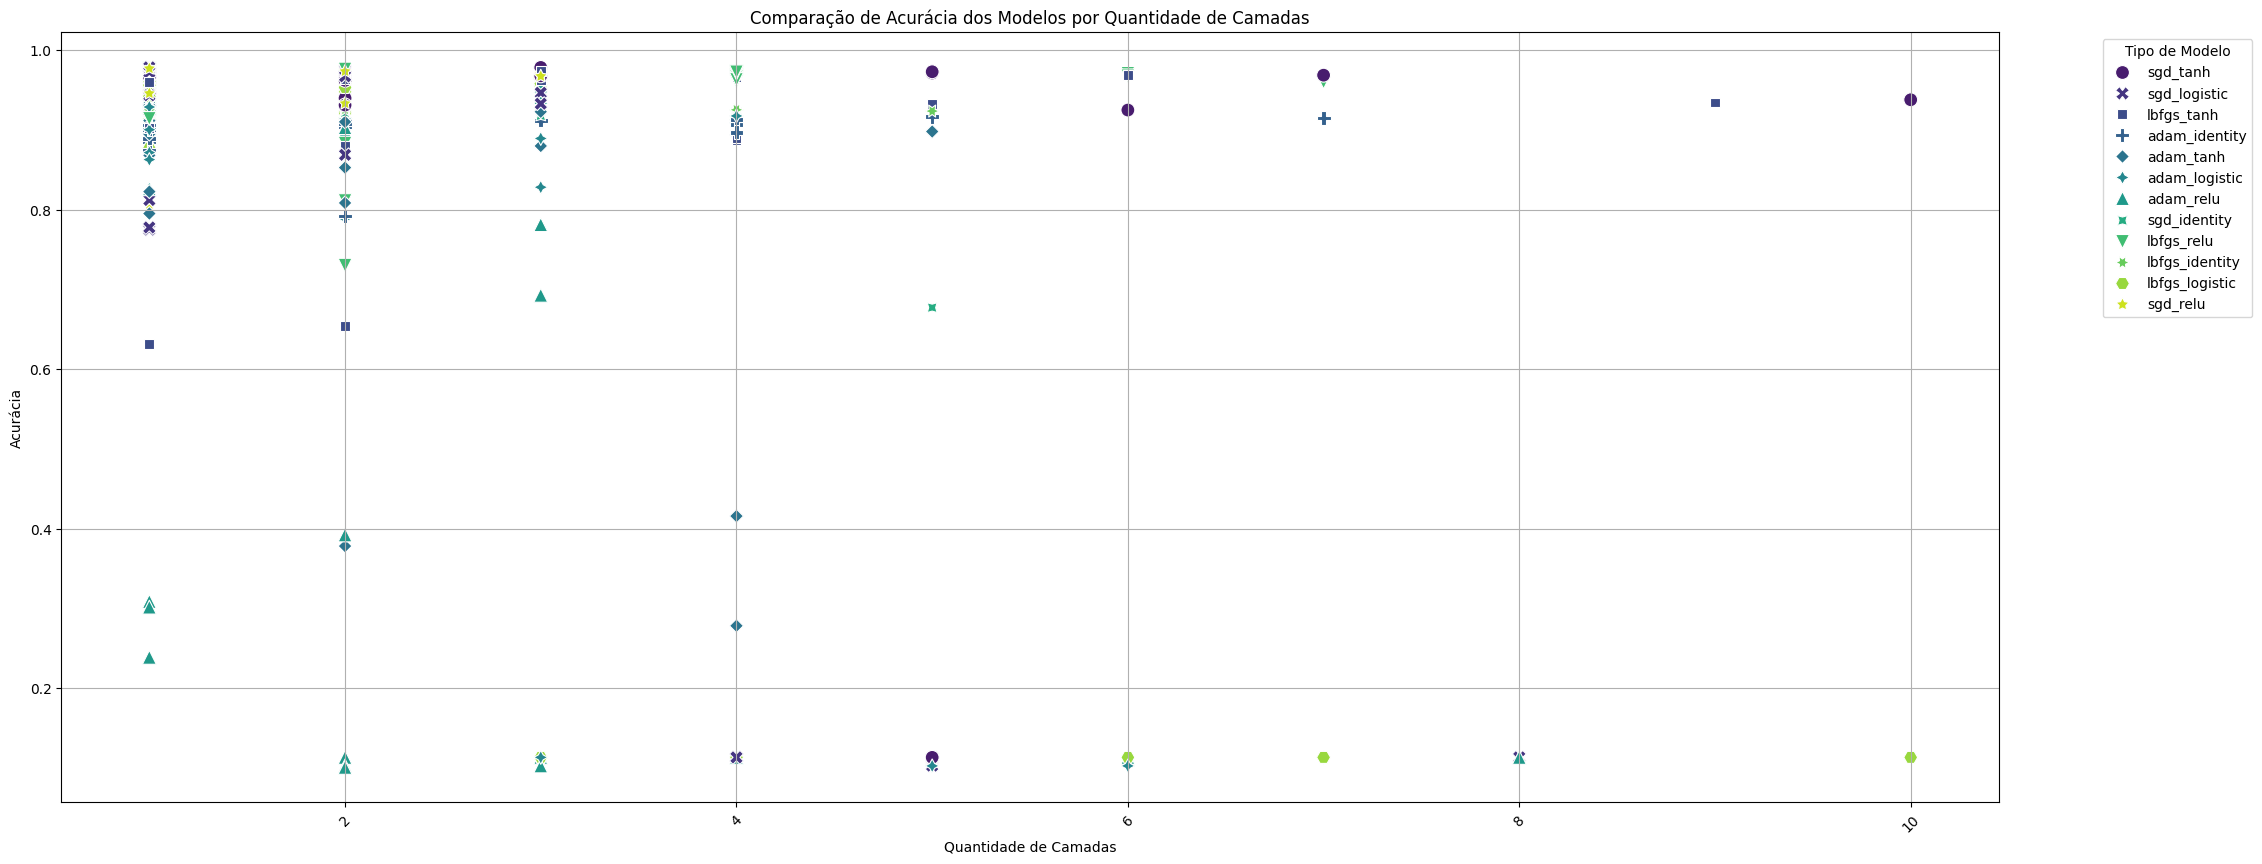

In [37]:
model_df['num_layers'] = model_df['hidden_layers'].apply(lambda x: len(eval(x)))

plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=model_df, x='num_layers', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)  # Ajustando o tamanho dos pontos para melhor visualização

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Quantidade de Camadas')
plt.xlabel('Quantidade de Camadas')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')  # Movendo a legenda para fora do gráfico

plt.show()

### Acurácia x Learning Rate

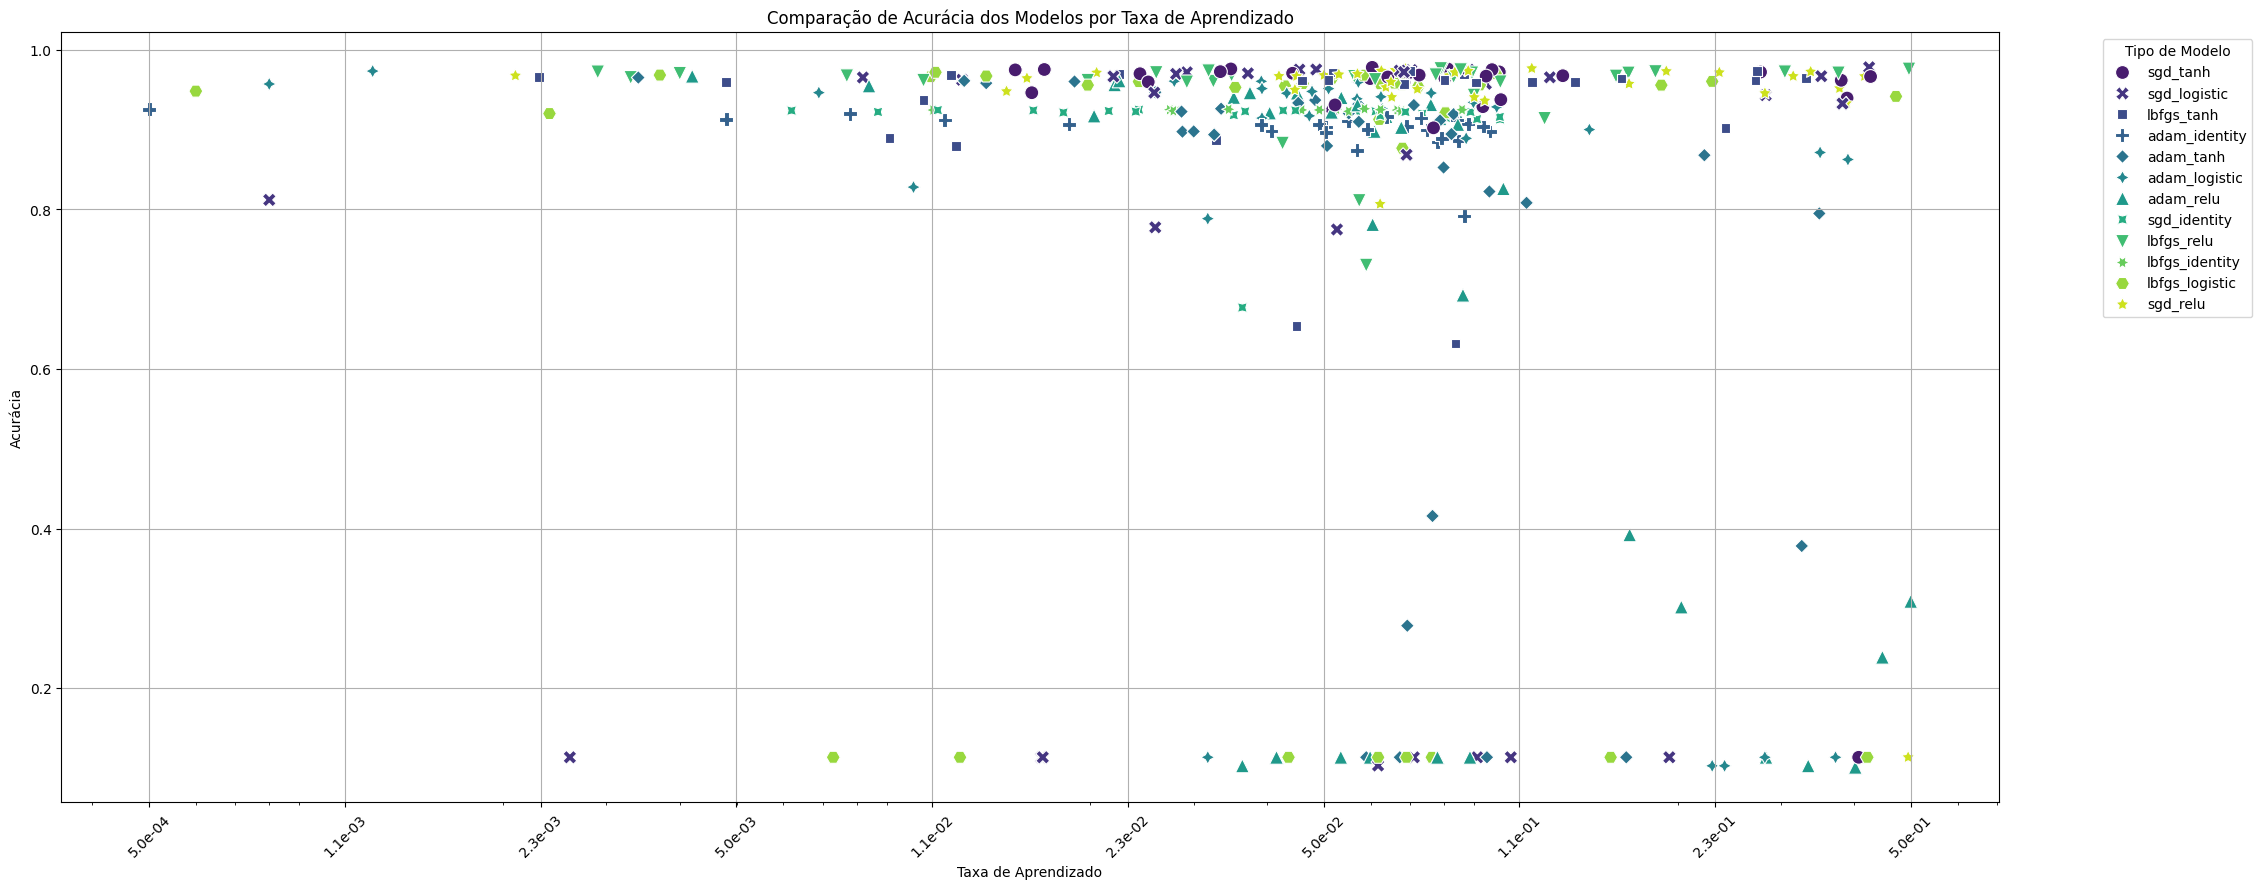

In [38]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.scatterplot(data=model_df, x='learning_rate', y='accuracy', hue='model_type', style='model_type',
                markers=True, palette='viridis', s=100)

# Personalizando o gráfico
plt.title('Comparação de Acurácia dos Modelos por Taxa de Aprendizado')
plt.xlabel('Taxa de Aprendizado')
plt.ylabel('Acurácia')
plt.xscale('log')  
# Ajustando os ticks do eixo x para maior granularidade
min_lr = model_df['learning_rate'].min()
max_lr = model_df['learning_rate'].max()
ticks = np.logspace(np.log10(min_lr), np.log10(max_lr), num=10)  
plt.xticks(ticks, labels=[f"{x:.1e}" for x in ticks])  
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Tipo de Modelo', bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.show()

## Verificando as métricas por classe do melhor modelo

In [24]:
infoClass = infoClass.transpose()

In [25]:
infoClass

,precision,recall,f1-score,support,accuracy
0,0.983707,0.985714,0.984709,980.0,0.985714
1,0.992049,0.989427,0.990737,1135.0,0.989427
2,0.970363,0.983527,0.976901,1032.0,0.983527
3,0.969185,0.965347,0.967262,1010.0,0.965347
4,0.987603,0.973523,0.980513,982.0,0.973523
5,0.953261,0.983184,0.967991,892.0,0.983184
6,0.981112,0.975992,0.978545,958.0,0.975992
7,0.969171,0.978599,0.973863,1028.0,0.978599
8,0.982255,0.966119,0.974120,974.0,0.966119
9,0.976931,0.965312,0.971087,1009.0,0.965312


#### Acurácia de cada classe do modelo

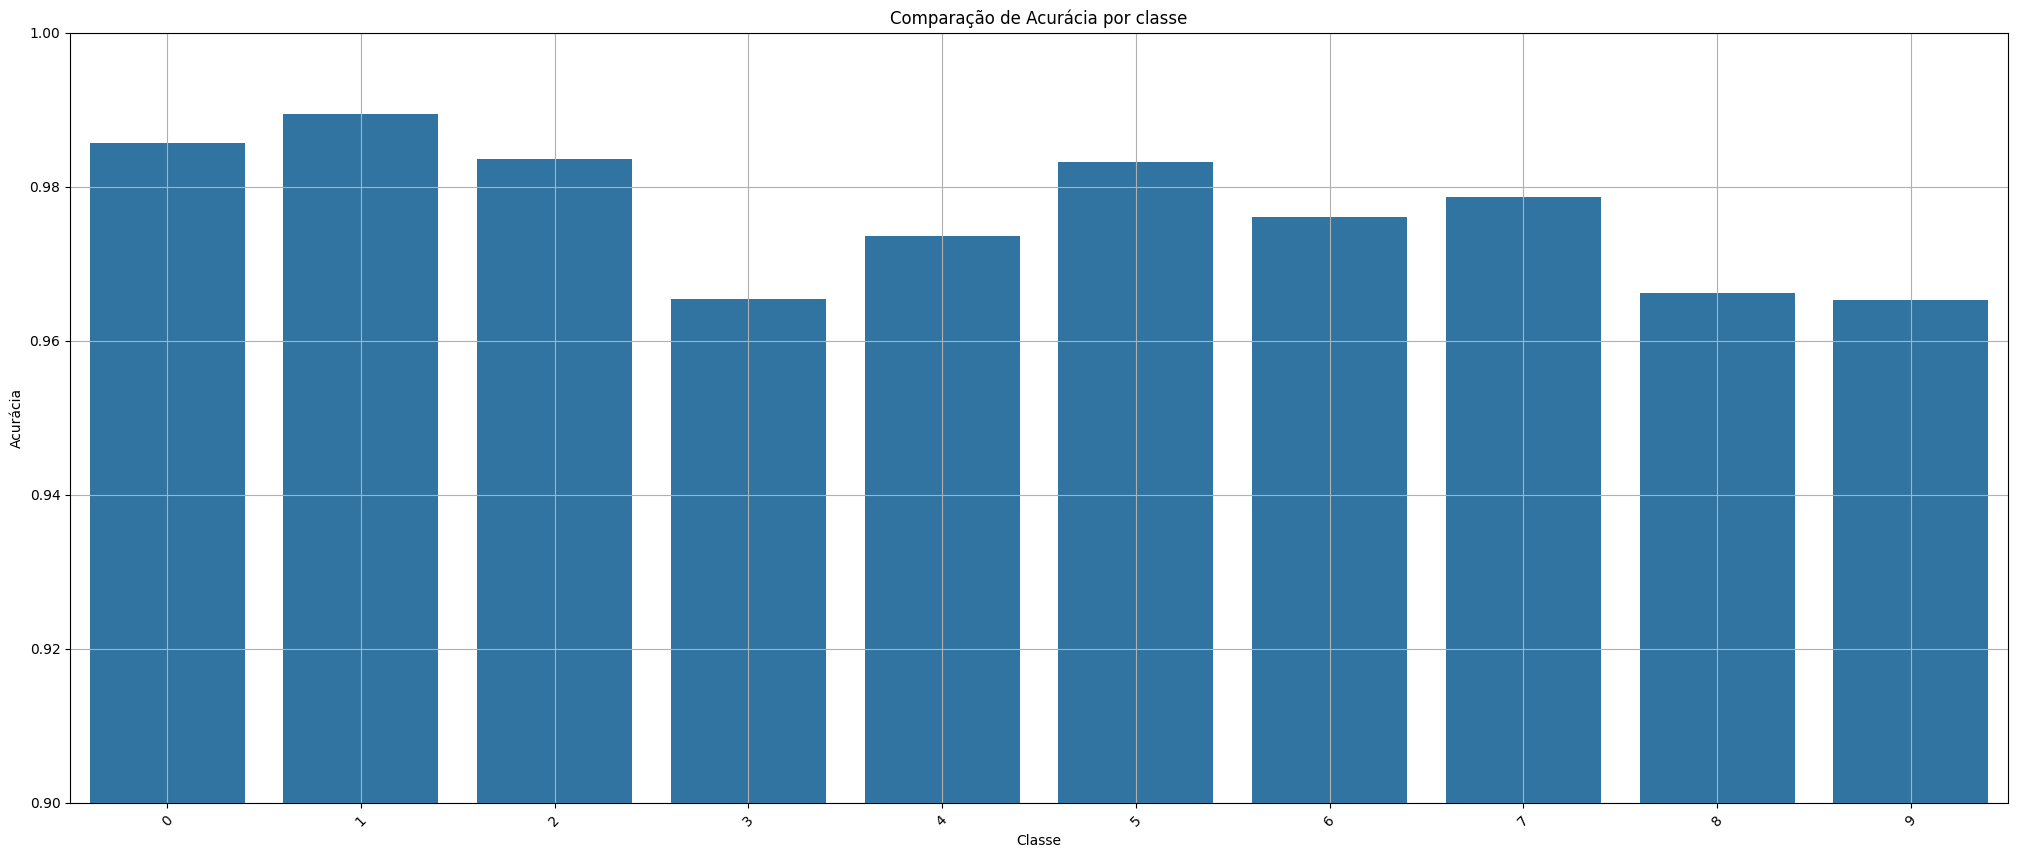

In [30]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.barplot(data=infoClass, x=infoClass.index, y='accuracy')

# Personalizando o gráfico
plt.title('Comparação de Acurácia por classe')
plt.xlabel('Classe')
plt.ylabel('Acurácia')
plt.xticks(rotation=45)
plt.grid(True)

plt.ylim(0.9, 1.0) 

plt.show()

##### Recall de cada classe do modelo

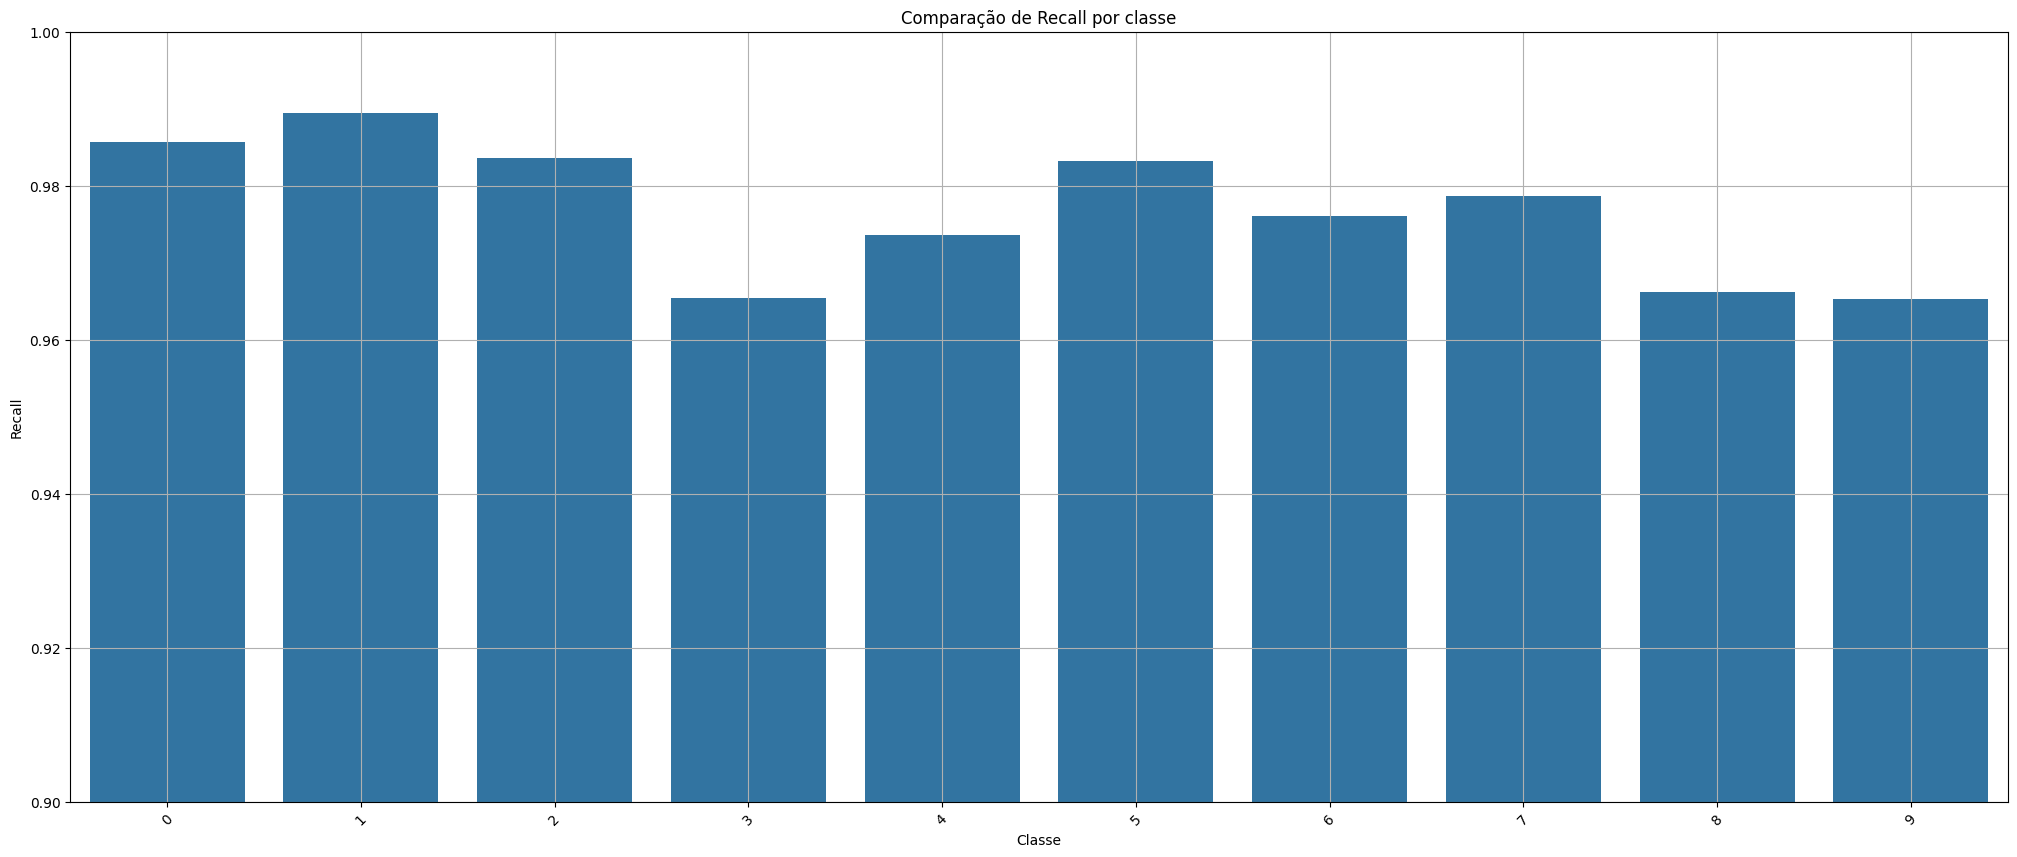

In [31]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.barplot(data=infoClass, x=infoClass.index, y='recall')

# Personalizando o gráfico
plt.title('Comparação de Recall por classe')
plt.xlabel('Classe')
plt.ylabel('Recall')
plt.xticks(rotation=45)
plt.grid(True)

plt.ylim(0.9, 1.0) 

plt.show()

#### Precision de cada classe do modelo

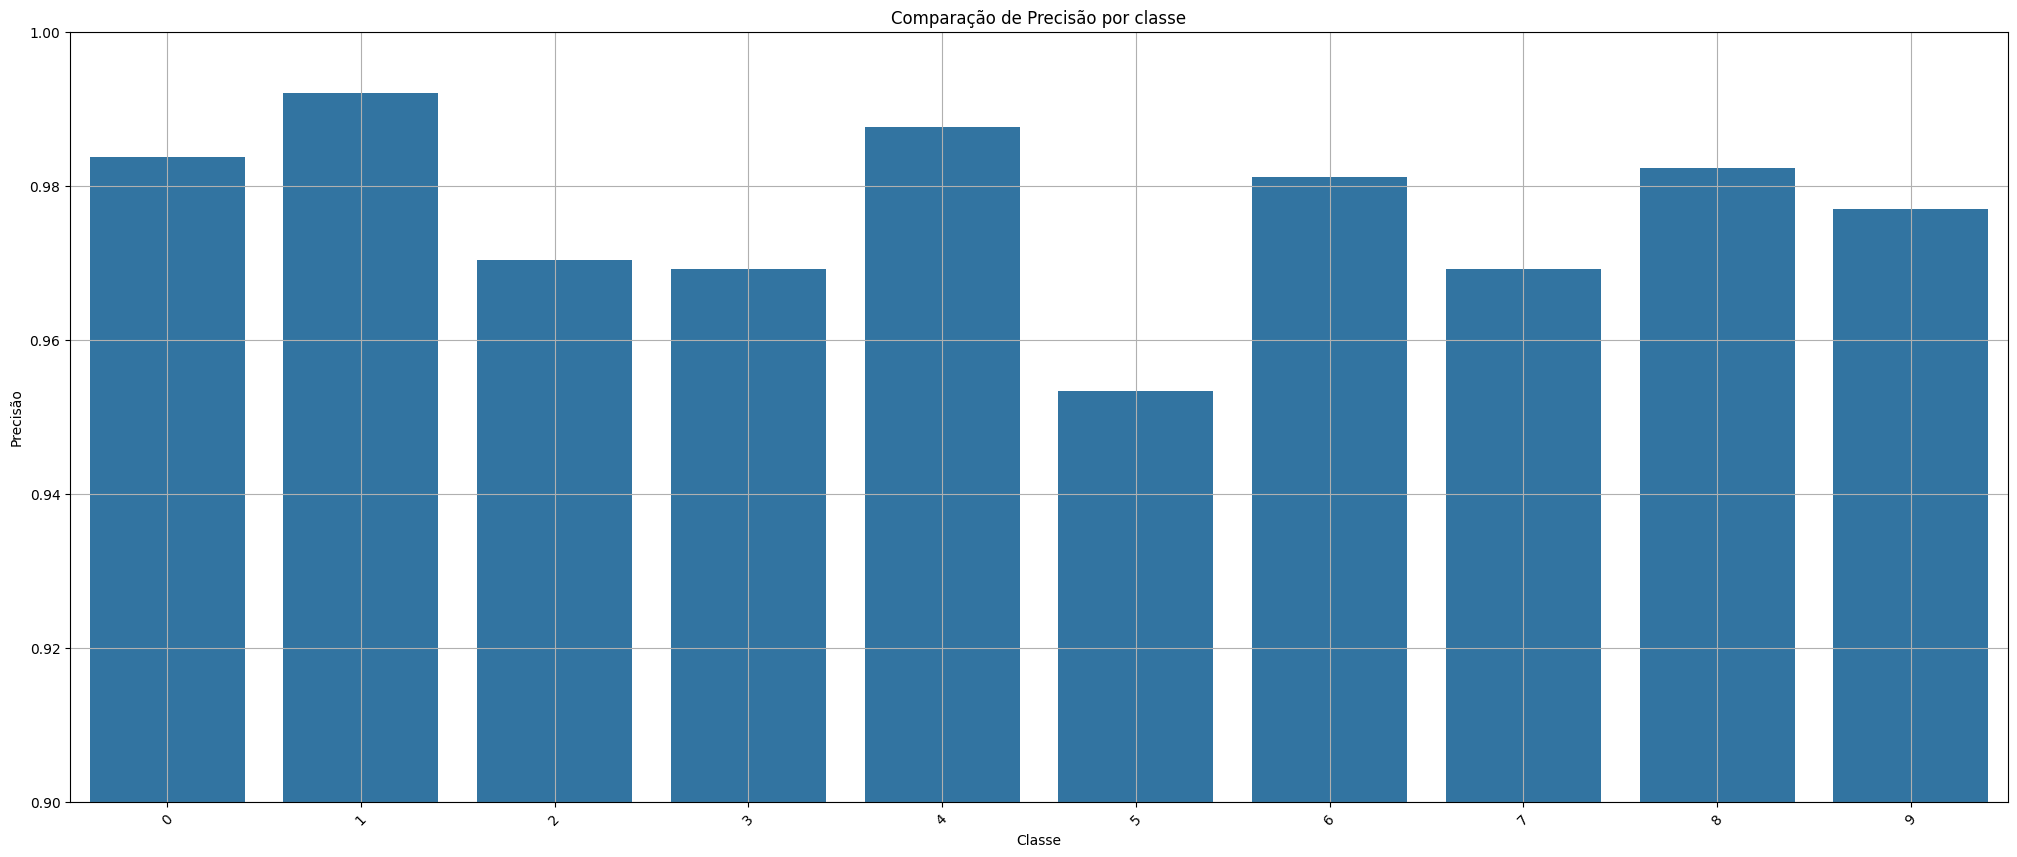

In [32]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.barplot(data=infoClass, x=infoClass.index, y='precision')

# Personalizando o gráfico
plt.title('Comparação de Precisão por classe')
plt.xlabel('Classe')
plt.ylabel('Precisão')
plt.xticks(rotation=45)
plt.grid(True)

plt.ylim(0.9, 1.0) 

plt.show()

#### F1-Score de cada classe do modelo

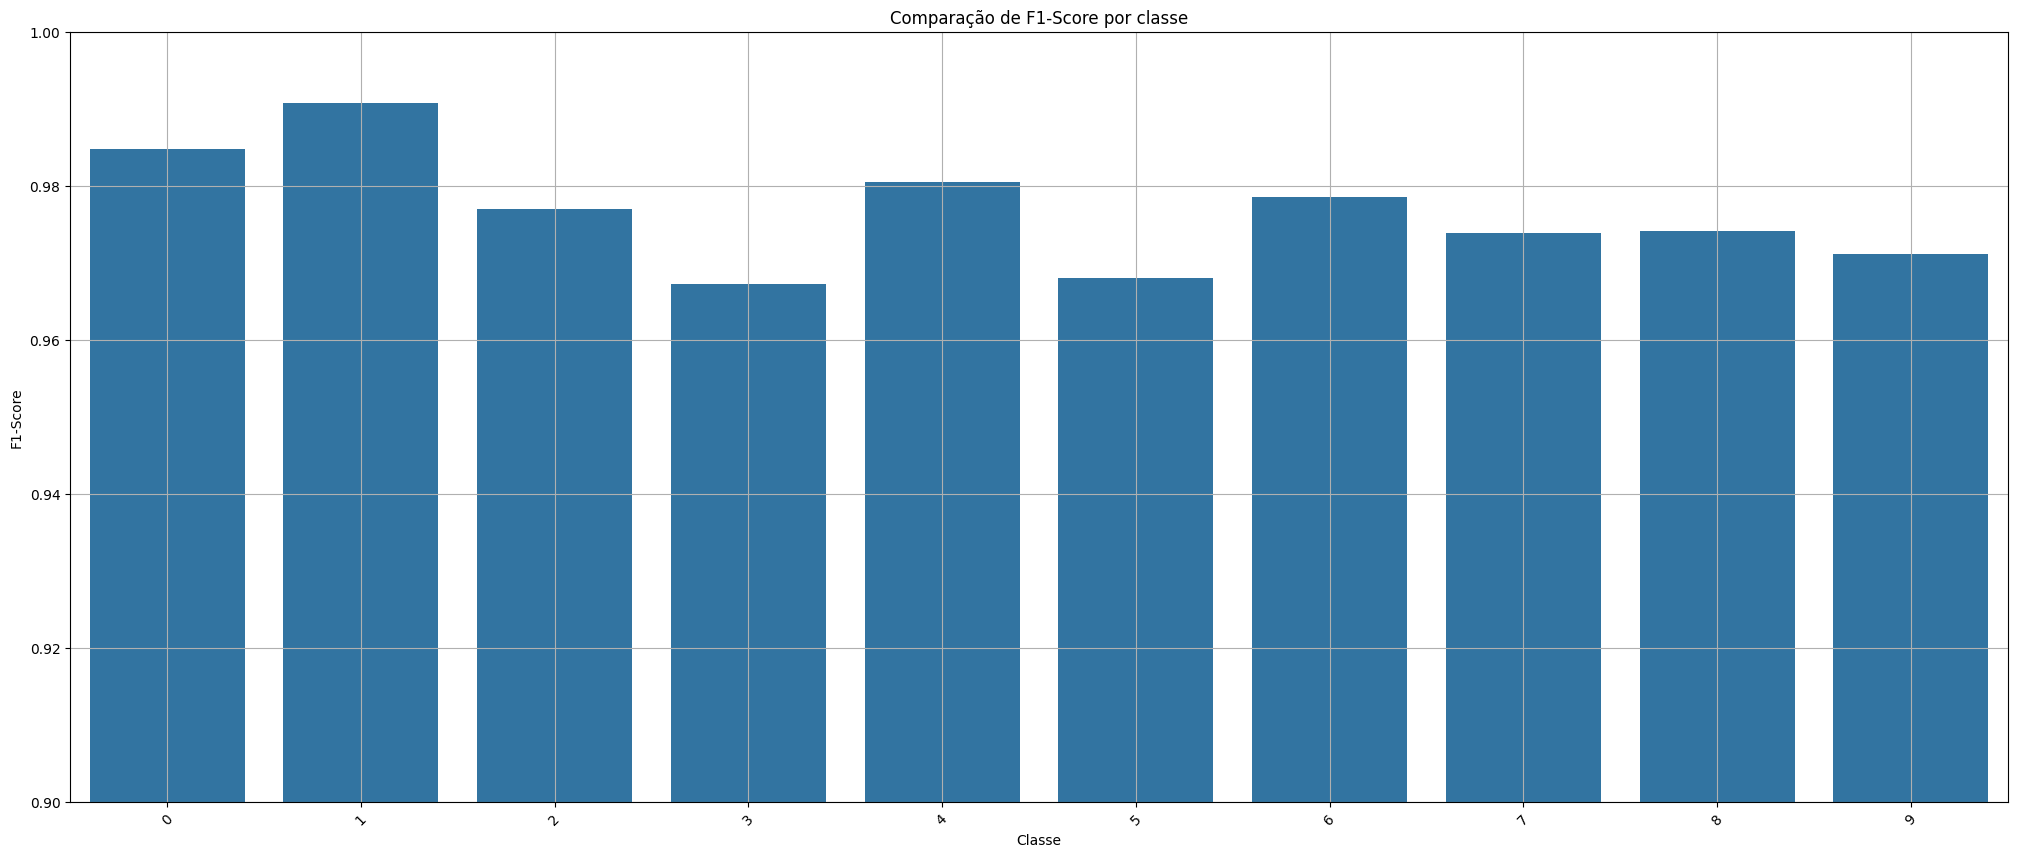

In [33]:
plt.figure(figsize=(25, 10))

# Plotando o gráfico de dispersão
sns.barplot(data=infoClass, x=infoClass.index, y='f1-score')

# Personalizando o gráfico
plt.title('Comparação de F1-Score por classe')
plt.xlabel('Classe')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.grid(True)

plt.ylim(0.9, 1.0) 

plt.show()